# 🤖 BERT Fine-Tuning for Sentiment Classification

In this project you will revisit the sentiment classification task that we did in Assignment 1. However, instead of a BOW classifier, you will build a neural network classifier by fine-tuning a pretrained language model. This approach to building classifiers is the current state-of-the-art, so learning how to do this should set you up very well for many future NLP problems you may want to tackle! 

The main learning objectives for this assignment are:
1. Understand how to design a basic experimental loop in PyTorch (loading data, training, and evaluating a model)
2. Learn how to navigate and follow online documentation for PyTorch and HuggingFace. 
3. Observe the effect of pretraining on model performance, and understand how "fine-tuning" differs from traditional model training. 

**Note**: An important goal of this assignment is to teach you how to use online documentation. The world of deep learning libraries and codebases --specifically for NLP-- is rapidly evolving as interest in the field is growing and researchers increasingly opensource their code. As a result, a critical skill of successful NLP researchers and engineers is the ability to learn how to write code on one's own by reading documentation and looking at examples. [PyTorch](https://pytorch.org/docs/stable/index.html) and [Hugging Face](https://huggingface.co/docs) have great documentation. You may use whatever documentation you'd like, however you **cannot ask questions on Stack Overflow or any platform except for those specifically created by the course staff (e.g. Edstem)**.

We require you to implement the training and testing loops from native PyTorch, **you may not use the Hugging Face Trainer API**. However, in reality, one would use the Trainer API - [here](https://huggingface.co/docs/transformers/main_classes/trainer) is the documentation for it.

### ❗ **Remember to copy this notebook** ❗

## Imports and package installation

These are all of the packages available for use during this assignment, they're all you should need. They must first be installed on this runtime, and then imported.

In [ ]:
!pip install transformers torch datasets tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch, codecs, random
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from datasets import load_metric
from google.colab import output
import matplotlib.pyplot as plt
import numpy as np
output.enable_custom_widget_manager()

If the following fails, your current Colab runtime doesn't have a GPU :( . To fix this, simply select 'Runtime' -> 'Change runtime type', then select 'GPU' under 'Hardware accelerator' and then press save.

In [ ]:
if not torch.cuda.is_available():
  print("Sorry, currently CUDA is not available!")
else:
  print("The CUDA is available now!")

The CUDA is available now!


## Part 1 - Baseline model


### 1. Dataset loading:

We need to load the dataset. For this assignment, [the same dataset as in assignment 1](https://drive.google.com/file/d/1AF2v6Cu_gNTe7lzpz_4zsMWMgJ-XjuSh/view?usp=sharing) is used. The dataset has to be uploaded to this runtime, the left sidebar can be used to do so:
1. Click on the 'Files' tab of the sidebar
2. Click on the 'Upload' button that should now be exposed, and select the dataset from wherever you downloaded it

The dataset contains a total of 5,000 labeled examples, the first 3,000 of which may be used in training. The next 1,000 can be used as a validation set, and the final 1,000 should be used for testing. The `'text'` column contains a raw Tweet, and the `'sentiment'` column contains the label (`'negative'`, `'neutral'`, or `'positive'`).

In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
FILEPATH = "/content/drive/MyDrive/CSCI1460/Assignment_3/"
dataset = pd.read_csv(FILEPATH + 'Tweets_5K.csv', header=0, sep=',')

# X should be raw review text, y should be integer labels ('negative' - 0, 'neutral' - 1, 'positive' - 2)
# X: List<String>
# y: List<int>

# Add a label to each class
dataset['label'] = pd.Categorical(dataset['sentiment']).codes
# dataset[0:10]

X = dataset['text'].values.tolist()
y = dataset['label'].values.tolist()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Next, we need to define a child class to the Pytorch `Dataset` class, such that we can customize it for our specific dataset, and also configure the tokenizer (which we'll initialize in a moment). The `__getitem__` function is what will be used to fetch all training examples by the eventual dataloader. `__getitem__` needs to tokenize the input reviews in the BERT fashion ([CLS] and [SEP] tokens need to be inserted as discussed in lecture, etc.) 

This has been written for you. 

In [ ]:
class ReviewDataset(torch.utils.data.Dataset):

  def __init__(self, reviews, sentiments, tokenizer):

    self.reviews = reviews
    self.sentiments = sentiments
    self.tokenizer = tokenizer
    self.max_len = tokenizer.model_max_length

  def __len__(self):

    return len(self.reviews)

  def __getitem__(self, index):

    review = str(self.reviews[index])
    sentiments = self.sentiments[index]

    encoded_review = self.tokenizer.encode_plus(
      review,
      add_special_tokens      = True,
      max_length              = self.max_len,
      return_token_type_ids   = False,
      return_attention_mask   = True,
      return_tensors          = "pt",
      padding                 = "max_length",
      truncation              = True
    )

    return {
      'input_ids': encoded_review['input_ids'][0],
      'attention_mask': encoded_review['attention_mask'][0],
      'labels': torch.tensor(sentiments, dtype=torch.long)
    }

### 2. Tokenizer and dataloader:
 

Now that we have the `ReviewDataset` class, you must construct the appropriate instances for our training, validation, and testing sets. Afterwhich, they must be used to construct PyTorch `DataLoader` instances (refer to PyTorch documentation). 

At this point, batch sizes will have to be specified. This may require some experimentation, as the larger the batch size, the faster the models will train, however they will also use more VMEM (Video Memory, like RAM, but on a GPU). If you get an error during training or testing about running out of memory, reduce your batch sizes here. 

Finally, we'll load the distilbert-base-uncased tokenizer from Hugging Face, the tokenizer that will be applied to the review text.

In [ ]:
from transformers import AutoTokenizer
from torch.utils.data import DataLoader

# use this for the tokenizer argument of the TweetDataset
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

# define the following dataset objects... be careful to split the data as previously specified 

# The first 3,000 are used in training;
# The next 1,000 are used as a validation set;
# The final 1,000 should be used for testing.
train_dataset = ReviewDataset(X[:3000], y[:3000], tokenizer)
validation_dataset = ReviewDataset(X[3000:4000], y[3000:4000], tokenizer)
test_dataset = ReviewDataset(X[4000:], y[4000:], tokenizer)

# now construct DataLoader objects from the TweetDataset objects
# remember that the TweetDataset class is a child class of torch.utils.data.Dataset
batch_num = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_num, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_num, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_num, shuffle=True)


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

### 3. Loading model:

Here we use the Hugging Face transformers library to load the architecture of the distilbert-base-uncased model. This model (DistilBERT) is usually trained for a masked language modeling, you can read more about it [here](https://huggingface.co/distilbert-base-uncased). It's basically a smaller version of BERT, which was covered in lecture (it's been '[distilled](https://arxiv.org/abs/1910.01108)').

In [ ]:
from transformers import AutoConfig, AutoModelForSequenceClassification

# getting the distilbert-base-uncased config...
config = AutoConfig.from_pretrained("distilbert-base-uncased", num_labels=3)
# ...from which we can use AutoModelForSequenceClassification to instantiate 
# an untrained version of the above model, read Hugging Face documentation
# to figure out how to do so!
untrained_model = AutoModelForSequenceClassification.from_config(config)

# print(config)
# print(untrained_model)

### 4. Evaluation loop:

We need to define an evaluation function, such that we can measure a model's performance on a dataset. 

For evaluation, there are a couple of steps that must be taken. For each batch in the evaluation set:
1. Apply the model on the batch inputs (feedforward)
2. Obtain the predictions, as well as the labels
3. Record the desired metrics based on the outputs and labels

PyTorch documentation is your friend - the function signature is also provided.

In [ ]:
def update_metrics(metrics, predictions, labels):
  """ Update a list of metrics with new predictions and labels
  
  :param list<datasets.Metric> metrics: list of metrics
  :param torch.Tensor predictions: tensor of predictions of shape (1, batch_size)
  :param torch.Tensor labels: tensor of labels of shape (1, batch_size)

  :return None
  """
  # Nothing TODO here! This updates metrics based on a batch of predictions
  # and a batch of labels.
  for metric in metrics:
    metric.add_batch(predictions=predictions, references=labels)

def evaluate(model, test_dataloader, device, metric_strs):
  """ Evaluate a PyTorch Model
  
  :param torch.nn.Module model: the model to be evaluated
  :param torch.utils.data.DataLoader test_dataloader: DataLoader containing testing examples
  :param torch.device device: the device that we'll be training on
  :param list<string> metric_strs: the names of Hugging Face metrics to use

  :return dictionary<string, float>: dictionary of metrics names mapped to their values
  """
  # load metrics
  metrics = [load_metric(x) for x in metric_strs] # could add more here!
  model.eval()

  # we like progress bars :)
  progress_bar = tqdm(range(len(test_dataloader)))

  for batch in test_dataloader:
    # TODO: fill in!

    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    preds_logits = outputs.logits 
    preds = torch.argmax(preds_logits, dim=-1)
    
    # Update the metrics
    update_metrics(metrics, preds, batch['labels'])

    progress_bar.update(1)
    
  # compute and return metrics
  computed = {}
  for m in metrics:
    computed = {**computed, **m.compute()}

  return computed

### 5. Baseline performance:

*Warning: Be aware that since this is a Jupyter Notebook, sometimes it is necessary to re-execute the cell defining the models in order to restart training from scratch. Also, sometimes 'CUDA out of memory' errors are due to past models residing on the GPU, the easiest way to fix this is to restart the Colab runtime (CTRL + M + .), or to run a cell that deletes models (`del <model>`). A batch size of 32 for training should be small enough such that models train without memory issues. To change the batch size, modify the `batch_size` parameter passed when initializing the `DataLoader`.*

Now that we have an untrained model, our dataset, and an evalutation function, we can evaluate the to find our baseline accuracies!

The next cell contains some code to make nice accuracy plots.

In [ ]:
from scipy.stats import describe
from math import sqrt

def make_plots(perfs, names):
  for perf, name in zip(perfs, names):
    print(f"{name} accuracy: {perf}")
  plt.bar(np.arange(len(perfs)), perfs)
  plt.xticks(np.arange(len(names)), names)
  plt.show()

Now, let's execute our training loop on the testing set. In terms of metrics, we'll only keep track of accuracy for now, however you can add others to the metric list (check the Hugging Face datasets documentation).


We should see that the baseline (expectedly) performs poorly.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate


  0%|          | 0/32 [00:00<?, ?it/s]

Baseline accuracy: 0.431


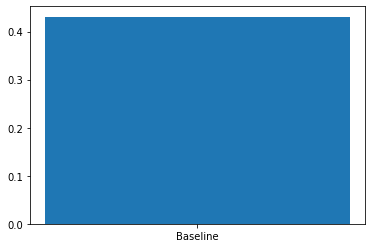

In [ ]:
# This gives us a way to use the GPU to run models! 
# For any parameter named 'device', pass the following variable:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# this loads all of the model parameters onto the device that we're using
untrained_model.to(device)

metrics = ['accuracy']
# TODO: evaluate on the test dataset
baseline_result = evaluate(untrained_model, test_dataloader, device, metrics)['accuracy']

# now, plot! Do not modify the following:
results = [baseline_result]
names = ['Baseline']
make_plots(results, names)

## Part 2 - Model trained from scatch




### 1. Defining the training loop:

The training loop follows similar steps to the evaluation loop:
For each batch in each epoch:
1. Apply the model on the batch inputs (feedforward)
2. Compare the predictions with the labels and calculate the loss
3. Backpropagate the loss and obtain gradients for all parameters
4. Apply the optimizer to the parameters and gradients

In addition to this, we'd like to keep track of some metrics during each epoch, and at the end of an epoch we want to run an evaluation on the validation set (you can use the evaluation loop!). Specifically, we want to know the training accuracy (accuracy measured against the training set) and validation accuracy - they can be reported through `print` statements.

**A note on logits**: Logits are unnormalized predictions of a model. In this case, we have three classes: negative, neutral, or positive. One can assign a single output at the end of a model to each of these classes. For our purposes we can take the prediction of the model to be the class with the maximum of these three values (take the argmax across the outputs), but we could additionally determine the model's confidence in the input belonging to each class by applying a normalizing function to the logits, one such function is softmax (no need to do this here)! The argmax of the logits is our prediction, which can be compared to the label. This may be useful when tracking metrics. This is important here since DistilBERT's classifier outputs logits...

Reading [PyTorch](https://pytorch.org/docs/stable/index.html) documentation should be very useful here. We'll provide the function signature.

In [ ]:
from datasets import load_metric

def train(model, optimizer, num_epochs, train_dataloader, validation_dataloader, lr_scheduler, device):
  """ Train a PyTorch Module
  
  :param torch.nn.Module model: the model to be trained
  :param torch.optim.Optimizer optimizer: the training optimizer
  :param int num_epochs: number of epochs to train for
  :param torch.utils.data.DataLoader train_dataloader: DataLoader containing training examples
  :param torch.utils.data.DataLoader validation_dataloader: DataLoader containing validation examples
  :param _ lr_scheduler: learning rate scheduler
  :param torch.device device: the device that we'll be training on
  
  :return None
  """

  for epoch in range(num_epochs):
    # put the model in training mode (important that this is done each epoch,
    # since we put the model into eval mode during validation)
    model.train()

    # load metrics
    metrics = [load_metric(x) for x in ["accuracy"]] # could add more here!

    print(f"Epoch {epoch + 1} training:")
    progress_bar = tqdm(range(len(train_dataloader)))

    for i, batch in enumerate(train_dataloader):
      # TODO: fill in!

      # Input the current batch
      batch = {k: v.to(device) for k, v in batch.items()}
      outputs = model(**batch)

      # Get loss and logits
      loss = outputs.loss
      logits = outputs.logits

      # Update
      loss.backward() # Backpropagation
      optimizer.step()
      lr_scheduler.step()
      optimizer.zero_grad() 
      
      # Update the metrics
      preds = torch.argmax(logits, dim=-1)
      update_metrics(metrics, preds, batch["labels"])

      progress_bar.update(1)

    # print the epoch's average metrics
    print(f"Epoch {epoch+1} average training metrics: accuracy={metrics[0].compute()['accuracy']}")

    # normally, validation would be more useful when training for many epochs
    print("Running validation:")
    # TODO: evaluate model on validation dataset
    val_metrics = evaluate(model, validation_dataloader, device, ["accuracy"])
    print(f"Epoch {epoch+1} validation: accuracy={val_metrics['accuracy']}")
        

### 2. Training the untrained model:

Great - now that we've define our training function, we can use it to try to train the untrained model from scratch! Train the model for **2 epochs**!

**A note on warmup steps, optimizers**: Optimizers like AdamW try to adapt the learning rate for individual parameters by collecting statistics about them. Warmup impacts some optimizers. Warmup steps allow the statistics calculated by some optimizers to converge before the optimizer starts to update parameters impactfully. During the warmup, the optimizer is updating parameters, but just by a much smaller magnitude than usual. Read more about optimizers [here](https://www.analyticsvidhya.com/blog/2021/10/a-comprehensive-guide-on-deep-learning-optimizers/#:~:text=While%20training%20the%20deep%20learning,loss%20and%20improve%20the%20accuracy.), and warmup [here](https://d2l.ai/chapter_optimization/lr-scheduler.html#warmup). 

First, we need to set up our optimizer, learning rate scheduler, and determine the number of epochs to train for. These are all parameters to the `train` function.

In [ ]:
from transformers import get_scheduler

num_epochs = 2

# here, we use the AdamW optimzer. Use torch.optim.AdamW. 
# intantiate it on the untrained model parameters with a learning rate of 5e-5
optimizer = torch.optim.AdamW(
    params = untrained_model.parameters(),
    lr = 5e-5,
)

# now, we set up the learning rate scheduler
lr_scheduler = get_scheduler(
  "linear",
  optimizer=optimizer,
  num_warmup_steps=50,
  num_training_steps=len(train_dataloader) * num_epochs
)

In [ ]:
torch.cuda.empty_cache()
untrained_model.to(device)

# TODO: now call your training loop!
train(untrained_model, optimizer, num_epochs, train_dataloader, validation_dataloader, lr_scheduler, device)

Epoch 1 training:


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 1 average training metrics: accuracy=0.378
Running validation:


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1 validation: accuracy=0.388
Epoch 2 training:


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 2 average training metrics: accuracy=0.49033333333333334
Running validation:


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2 validation: accuracy=0.539


Hypothetically, the untrained model is now slightly trained - yet based on the validation scores, things didn't go that well. 

### 3. Evaluate the trained model:

Call the evaluation loop on the model we just trained! View the bar graph to compare it to the baseline.

  0%|          | 0/32 [00:00<?, ?it/s]

Baseline accuracy: 0.431
Manually Trained accuracy: 0.538


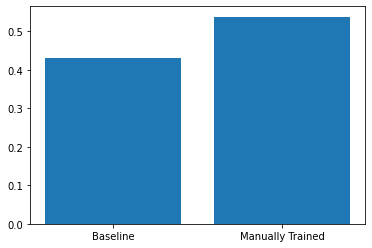

In [ ]:
metrics = ['accuracy']

# TODO: Evaluate on test dataset!
trained_result = evaluate(untrained_model, test_dataloader, device, metrics)['accuracy']

# now, plot! Do not modify the following:
results = baseline_result, trained_result
names = ['Baseline', 'Manually Trained']
make_plots(results, names)

As you can see, this model achieves an accuracy of around 55% after the first two epochs. Training it for further epochs (which you don't need to do) renders minimal improvement. To achieve better performance when training DistilBERT from scratch for this purpose, we'd need a lot more data and a lot more time (and/or compute). Fortunately, there is a better way!

## Part 3 - Finetuning a pre-trained model

Since manually training the model didn't work very well, let's fine-tune a pre-trained model. 

### 1. Load pre-trained model:

This time, we'll make use of a pre-trained version of DistilBERT - everything's the same as before, but the model has actually been trained for a language modeling task.

In [ ]:
from transformers import DistilBertForSequenceClassification

# TODO: load the distilbert-base-uncased pre-trained model, use DistilBertForSequenceClassification
# from Hugging Face (transformers), read their documentation to do this.
# WARNING: This dataset has three classes! The default for this model is two!
pretrained_model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", 
    num_labels=3
)

# Ignore the warnings printed below.

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

Let's give it a test run...
To motivate, the pre-trained model isn't particularly good at this specific task out-of-the box, to see this, evaluate it on the test set just the way it is.

  0%|          | 0/32 [00:00<?, ?it/s]

Baseline accuracy: 0.431
Manually trained accuracy: 0.538
Pre-trained accuracy: 0.427


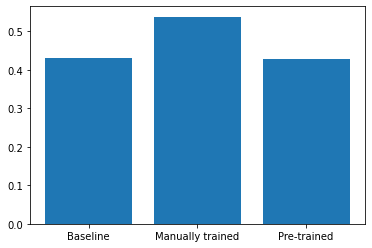

In [ ]:
# We have to move it to the device before doing anything with it!
pretrained_model.to(device)

# TODO: call evaluate on the pre-trained model!
pretrained_result = evaluate(pretrained_model, test_dataloader, device, metrics)['accuracy']

# now, plot! Do not modify the following:
results = [baseline_result, trained_result, pretrained_result]
names = ['Baseline', 'Manually trained', 'Pre-trained']
make_plots(results, names)

As we can see, without any fine-tuning, the pre-trained model performs rather badly. This makes sense, since DistilBERT is pre-trained on a masked language modelling task, so the classifier portion of DistilBERT isn't at all trained for sentiment classification (recall architecture and training of BERT from lecture).

### 2. Fine-tuning pre-trained model:

Rather than train the model from scratch, we'll now fine-tune the pre-trained model!
We'll fine-tune by simply running the `train` function on our pre-trained model with the training data! Fine-tune it for **2 epochs**.

In [ ]:
num_epochs = 2

# use the same kind of optimizer as before, but with the pretrained model's parameters
optimizer = torch.optim.AdamW(
    params = pretrained_model.parameters(),
    lr = 5e-5,
)

# this hasn't changed
lr_scheduler = get_scheduler(
  "linear",
  optimizer=optimizer,
  num_warmup_steps=50,
  num_training_steps=len(train_dataloader) * num_epochs
)

In [ ]:
torch.cuda.empty_cache()
pretrained_model.to(device)

# TODO: train!
train(pretrained_model, optimizer, num_epochs, train_dataloader, validation_dataloader, lr_scheduler, device)

Epoch 1 training:


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 1 average training metrics: accuracy=0.57
Running validation:


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1 validation: accuracy=0.733
Epoch 2 training:


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 2 average training metrics: accuracy=0.8103333333333333
Running validation:


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2 validation: accuracy=0.737


You should've seen a sneak-peak of the model's performance based on the validation accuracies!

### 3. Evaluating the fine-tuned model:

  0%|          | 0/32 [00:00<?, ?it/s]

Baseline accuracy: 0.431
Manually trained accuracy: 0.538
Pre-trained accuracy: 0.427
Fine-tuned accuracy: 0.746


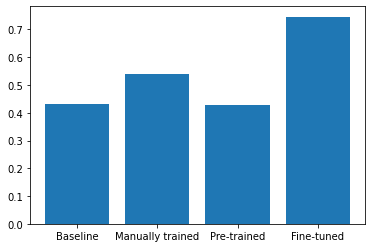

In [ ]:
# TODO: Evaluate the fine-tuned model on the test dataset
finetuned_result = evaluate(pretrained_model, test_dataloader, device, metrics)['accuracy']

# now, plot! Do not modify the following:
results = [baseline_result, trained_result, pretrained_result, finetuned_result]
names = ['Baseline', 'Manually trained', 'Pre-trained', 'Fine-tuned']
make_plots(results, names)

Wow! With just two epochs of training, and only 3k training examples, we can achieve ~75% accuracy (this should be attainable)! As we can see, the pre-trained model has a very noticeable advantage over the completely untrained one. Training for an additional epoch renders a slight improvement, afterwhich the fine-tuning begins to overfit on our training set, which can be judged by comparing the average epoch training accuracies and validation accuracies.

Additionally, remember that this was the dataset used in assignment 1, where you had to do significant pre-processing to get the accuracy to just ~65%! With ease (and less training data, since here we had a 60/20/20 split), DistilBERT has an even better performance (take it with a grain of salt, however, since we didn't do cross-validation).

## Part 4 - Extra Credit

Try some of the other transfer methods we described in class (e.g., zero-shot or in-context learning). You can experiment with [other pretrained models too](https://huggingface.co/models). Turn in a short report (2–5 pages) on what you tried, and how it performed compared to the fine-tuned model. 

If you do some experiments, organize them in code cells below and make sure that everything's been executed before you hand in!

In [ ]:
# Your code!

## Hand-in: 
To hand-in, first delete any debugging print statements, this helps us read your code. Then, go to Runtime->Restart and run all to run the entire notebook with your completed code. Then download the notebook as a .ipynb **and** .py file, and upload these to the Gradescope assignment. 

We would also like you to submit a link to your colab. Make sure you enable link sharing!

**LINK TO THIS COLAB:** https://colab.research.google.com/drive/1NmoBmiGTIoZJaFCXbUR4uo_woLkE7Z9A?usp=sharing